Week 5 Notebook: Deep Learning from Jet Images
===============================================================

Now, we'll look at a deep learning model based on jet images

In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import utils

In [2]:
import yaml

with open('definitions_image.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']

## Jet Images

Let's construct jet images {cite:p}`deOliveira:2015xxd`, which are 2D image-based representations of the spatial energy spread of jets. Each pixel's intensity is given by the sum of the transverse momentum of the particles located in that pixel.

In [5]:
#feature_array, y, spec_array = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/train/ntuple_merged_10.root', 
feature_array, y, spec_array = utils.get_features_labels('/work/train_ntuple_merged_10_small.root', 
                                                         features, spectators, labels,
                                                         remove_mass_pt_window=False,
                                                         entry_stop=1000)
# make image
X = utils.make_image(feature_array)
print(X.shape) # image is a 4D tensor (n_samples, n_pixels_x, n_pixels_y, n_channels)

(920, 224, 224, 1)


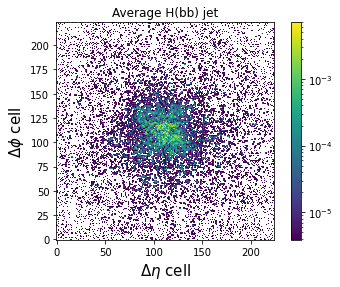

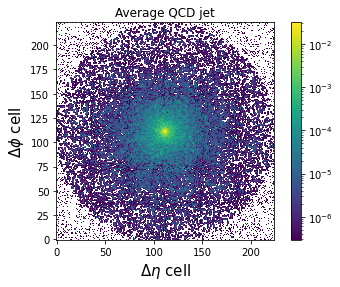

In [6]:
from matplotlib.colors import LogNorm

plt.figure()
plt.title('Average H(bb) jet')
plt.imshow(np.mean(X[y[:,1]==1],axis=0), origin='lower', norm=LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()

plt.figure()
plt.title('Average QCD jet')
plt.imshow(np.mean(X[y[:,0]==1],axis=0), origin='lower', norm=LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()

## 2D Convolutional Neural Network Classifier

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Conv2D, Flatten, MaxPooling2D, Activation
import tensorflow.keras.backend as K

# define dense keras model
inputs = Input(shape=(224,224,1), name = 'input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Conv2D(64, (3,3), padding='same', name = 'conv2d_1')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(name='bn_2')(x)
x = Activation('relu')(x)
x = Conv2D(32, (3,3), padding='same', name = 'conv2d_2')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(name='bn_3')(x)
x = Activation('relu')(x)
x = Conv2D(32, (3,3), padding='same', name = 'conv2d_3')(x)
x = MaxPooling2D(2,2)(x)
x = BatchNormalization(name='bn_4')(x)
x = Activation('relu')(x)
x = Flatten(name='flatten_1')(x)
x = Dense(256, name='dense_1', activation='relu')(x)
outputs = Dense(nlabels, name = 'output', activation='softmax')(x)
keras_model_conv2d = Model(inputs=inputs, outputs=outputs)
keras_model_conv2d.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_conv2d.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 224, 224, 1)]     0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 224, 224, 1)       4         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
bn_2 (BatchNormalization)    (None, 112, 112, 64)      256       
_________________________________________________________________
activation (Activation)      (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      18464 

In [ ]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(patience=5,factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_conv2d_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_conv2d = keras_model_conv2d.fit(X, y, validation_split = 0.2,
                                        epochs=20, 
                                        shuffle=True,
                                        callbacks = callbacks, 
                                        verbose=0)
# reload best weights
keras_model_conv2d.load_weights('keras_model_conv2d_best.h5')

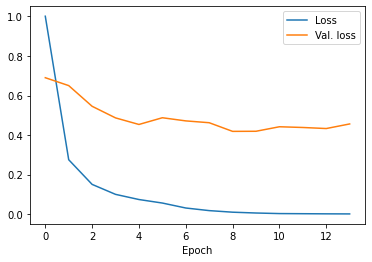

In [7]:
plt.figure()
plt.plot(history_conv2d.history['loss'],label='Loss')
plt.plot(history_conv2d.history['val_loss'],label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [8]:
# load testing file
#feature_array_test, label_array_test, spec_array_test = utils.get_features_labels('root://eospublic.cern.ch//eos/opendata/cms/datascience/HiggsToBBNtupleProducerTool/HiggsToBBNTuple_HiggsToBB_QCD_RunII_13TeV_MC/test/ntuple_merged_0.root',
feature_array_test, label_array_test, spec_array_test = utils.get_features_labels('/work/test_ntuple_merged_0_small.root',                                                                                
                                                                                  features, spectators, labels,
                                                                                  remove_mass_pt_window=False)
                      
# make image
X_test = utils.make_image(feature_array_test)

In [ ]:
# run model inference on test data set
predict_array_cnn2d = keras_model_conv2d.predict(X_test)

# create ROC curves
fpr_cnn2d, tpr_cnn2d, threshold_cnn2d = roc_curve(label_array_test[:,1], predict_array_cnn2d[:,1])
    
# plot ROC curves
plt.figure()
plt.plot(tpr_cnn2d, fpr_cnn2d, lw=2.5, label="Conv2D, AUC = {:.1f}%".format(auc(fpr_cnn2d,tpr_cnn2d)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()